# 결론 및 시도한 사항 정리

#### 감사인사
먼저 초반에 코드공유를 하여 참고한 분들께 감사인사를 올립니다.  
덕분에 참고하여 더 좋은 성능을 낼 수 있었습니다.
 - [기세현]님
 - [동화]님
***
<br>

#### 최종제출 결론요약
1.모델성능: Cat > Extra > LGB > SVR  
2.앙상블과정
  - 튜닝된 모델 4개 대하여 k-fold(k=5) * lucky_seeds(4개) 교차검정 훈련을 통해 나온 모델 20개로 기하평균 -> 총 80개 모델 사용
  - 4개의 모델에 대해 기하평균된 4개의 csv로 성능이 작은 모델부터 하나씩 기하평균 -> gmean_from_low_score
  - 4개의 모델에 대해 기하평균된 4개의 csv로 성능이 높은 모델부터 하나씩 기하평균 -> gmean_from_top_score
  - gmean_from_low_score, gmean_from_top_score 두 개의 csv파일에 대해서 0.95와 0.05로 가중평균
***
<br>

#### 시도했던 것들
- < 피처 >  
피처는 기본피처의 성능확인부터 시작했습니다. 피처에 대한 정제, 엔지니어링 그 무엇이든 하나라도 적용시키게 되었을 때 과연 성능이 오르는가를 보았습니다. 성능지표는 mae외에도 mse와 r2를 보았고, 3개의 성능지표 중 대부분의 모델들에 대해서 기본성능이 전체적으로 오를경우 채택하였고 아닐경우 과감히 버렸습니다. 감사하게도 동화님께서 몇 개의 피처를 만들어 주셔서 가져다 사용하였는데, 이 경우에도 하나씩 붙여서 성능이 오르는 것은 가져가고 애매하거나 내려가는 것은 버렸습니다. 피처 중 비지도학습을 통한 피처생성은 이전에 다른 곳에서 사용한 것을 본적이 있어서 처음으로 적용하여 보았습니다. SVR모델만 라벨인코딩이 다른 피처를 사용하였습니다. 라벨인코딩의 범주형변수에 있어서 순서를 직접 세워주냐 안세워주냐의 차이인데, SVR모델 같은 경우는 순서를 세워주지 않은 것이 더 좋은 성능을 내었고 실제로 앙상블 결과 퍼블릭으로도 성능이 잘 나와서 SVR의 경우만 라벨인코딩이 다른 피처를 사용하였습니다. 원핫인코딩의 경우 캣에서 더 나은 성능을 보였지만 다른 모델의 경우는 라벨인코딩이 더 나은 성능을 보였고, 캣의 경우에만 다른 피처를 가져갔을 때 앙상블 성능이 좋지 않아 원핫인코딩은 버렸습니다.
<br>
<br>

- < 모델링 >  
모델링 같은 경우 시도한 것들 중 성능이 좋은 순서대로 나열하면 다음과 같습니다.  
    - Seed_Ensemble(제가 한 기법) + 기하평균 + 가중평균
    - 기하평균
    - Stk(meta_model들 튜닝한 것) + 기하평균
    - 산술평균
    - 가중평균
    - Voting(Averaging)
    - Stk(meta_model들 튜닝안함)
    - CatBoost(개별모델 중 가장 좋은 성능)  

튜닝은 베이지안으로 하였을 때 로컬은 좋지만 제가 잘 못 다루었는지 퍼블릭에서 오버피팅이 떠버려서, 랜덤서치로 iter를 200주고 하였습니다.
kfold의 k값이 5여서 캣에서 1시간 10분 ~ 30분정도 걸렸고, 다른 모델은 2분 정도 걸렸습니다. 위에 라이브러리에 있었던 모델들은 모두 성능을 보았는데, 모델들 중 성능이 너무 안나오는 것들을 제외하고 튜닝을 돌렸습니다. 튜닝 후에 Combination 모듈과 함께 Voting 성능 출력 결과 튜닝시킨 7개의 모델들의 모든 조합에 있어서 항상 Extra, Lgb, Cat, Svr의 조합이 가장 뛰어난 것들 보고 후반부터는 아에 4개의 모델로 고정하고 진행하였습니다.
모델링에서 이번에 시도하였던 것 중 Stacking의 메타 모델을 튜닝한게 유의미 했다는 점이 특이하였습니다. 메타모델로는 다른 모델들도 사용해 보았지만 NGB와 Ridge는 오버피팅이 심하였고, LGB도 피처가 줄어서 성능이 안나와 XGB로 대체하였습니다. 나중에 Stacking이 효능이 잘 나오는 곳에 적용해볼법 하다고 생각이 듭니다.
제가 사용한 씨드앙상블 기법은 매우 간단히 튜닝한 모델을 두고서 씨드만 바꾸어서 훈련시키고 성능이 좋은 씨드에 대해서만 학습시킨 모델들을 기하평균 내리는 방법입니다. 씨드를 찾기 위해서 1부터 1000까지 돌렸는데, 로컬상으로 5개의 성능이 좋은 씨드가 나왔고, 그 중 성능조합을 고려해 4개를 채택하여 학습시켰습니다. 튜닝된 하나의 모델로 좀 더 안정된 성능을 만드는 트릭같은 기법이라 생각하시면 될 것 같습니다. 기하평균을 할 때 원래는 4개를 한꺼번에 하였는데, 낮은 성능부터 순서대로 기하평균한 것이 성능이 훨씬 좋아서 낮은 성능부터 기하평균을 하였습니다. 그리고 마지막에는 성능의 가중치 조절을 위해서 높은 성능부터 순서대로 기하평균 한 것들에 0.05의 가중을 주고 낮은 순서대로 기하평균한 성능에 가중평균하였습니다.  

데이터가 적어서 많은 시도를 해볼 수 있었던 대회였습니다. 마지막에 퍼블릭 순위가 왔다갔다하는데 굉장히 쫄깃했습니다. private에서 우승하지 못한 것은 아쉽지만 그래도 1프로 안에 들어서 기쁘네요. 참고로 아래 코드는 공개하지 않을 예정의 일부 생략된 코드가 있습니다. 감사합니다

In [1]:
# Data Handling
import pandas as pd
import numpy as np
from tqdm import tqdm
import time
import datetime
import os
pd.set_option('max_rows', 200)
import warnings;warnings.filterwarnings('ignore')


# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', family='malgun gothic')
plt.rc('axes', unicode_minus=False)


# Data Engineering
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm, skew


# Modeling & Tuning
from sklearn.model_selection import KFold
n_splits=5; seed = 42
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from ngboost import NGBRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.model_selection import RandomizedSearchCV


# Ensemble
from itertools import combinations
from sklearn.ensemble import VotingRegressor
from mlxtend.regressor import StackingRegressor
from vecstack import StackingTransformer


# Evaluation
from sklearn.metrics import mean_absolute_error
from scipy.stats.mstats import gmean


# Save
import joblib



# Label Encoding for SVR
def labelEncode_features(train_data, test_data, columns):
    for column in columns:
        encoder = LabelEncoder()
        train_data[column] = encoder.fit_transform(train_data[column])
        test_data[column] = encoder.transform(test_data[column])
    return train_data, test_data

# Label Encoding for others
def label_encoder(df_, qual_cols):
    df = df_.copy()
    mapping={
      'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1
    }
    for col in qual_cols :
        df[col] = df[col].map(mapping)
    return df

# Cross_validate
def get_various_scores(model, feature_data, y_target):
    scoring = {'mae':'neg_mean_absolute_error', 'mse':'neg_mean_squared_error', 'r2':'r2'}
    scores = cross_validate(model, feature_data, y_target, scoring=scoring, cv=kfold, n_jobs=-1)
    avg_mae = np.mean(-1 * scores['test_mae'])
    avg_mse = np.mean(-1 * scores['test_mse'])
    avg_r2 = np.mean(scores['test_r2'])
    print(f'{model.__class__.__name__:30s} MAE: {avg_mae:.4f} / MSE: {avg_mse:.4f} / R2: {avg_r2:.4f}')


In [2]:
# 단일모델 정의
# knn_reg = KNeighborsRegressor(n_jobs=-1)
extra_reg = ExtraTreesRegressor(random_state=seed, n_jobs=-1)
rf_reg = RandomForestRegressor(random_state=seed, n_jobs=-1)
gbm_reg = GradientBoostingRegressor(random_state=seed)
xgb_reg = XGBRegressor(random_state=seed, n_jobs=-1)
lgb_reg = LGBMRegressor(random_state=seed, n_jobs=-1)
cat_reg = CatBoostRegressor(random_state=seed, verbose=False)
ngb_reg = NGBRegressor(random_state=seed, verbose=False)
svm_reg = SVR()
ridge_reg = Ridge(random_state=seed)
lasso_reg = Lasso(random_state=seed)
elastic_reg = ElasticNet(random_state=seed)
lr_reg = LinearRegression(normalize=True, n_jobs=-1)

basic_regs = [extra_reg, rf_reg, gbm_reg, xgb_reg, lgb_reg, cat_reg, ngb_reg, svm_reg, ridge_reg, lr_reg]
selected_regs = [extra_reg, lgb_reg, svm_reg, cat_reg]

In [3]:
train = pd.read_csv('./DATA/train.csv')
test = pd.read_csv('./DATA/test.csv')
target = train.target
sample_sub = pd.read_csv('./DATA/sample_submission.csv')

train.drop('id', axis=1, inplace=True)
test.drop('id', axis=1, inplace=True)

print(f'train: {train.shape},\ntest: {test.shape},\nsubmission: {sample_sub.shape}')

train: (1350, 14),
test: (1350, 13),
submission: (1350, 2)


# 데이터 정제

In [5]:
# '정제' refinement의 약자로 re를 붙임
train_re = train.copy()

In [6]:
# train의 'Garage Yr Blt'의 254번 데이터가 2207로 되어 있어서 2007로 변경(해당 데이터의 리모델링 연도가 2007이었음)
gar_outlier_idx = train_re[train_re['Garage Yr Blt'] == 2207].index
train_re.loc[gar_outlier_idx, 'Garage Yr Blt'] = 2007

In [7]:
# train의 'Kitchen Qual'의 인자로 있지 않은 'Po'를 가장 많은 'TA'로 변경
po_idx = test[test['Kitchen Qual']=='Po'].index
test.loc[po_idx, 'Kitchen Qual'] = 'TA'

2161.875


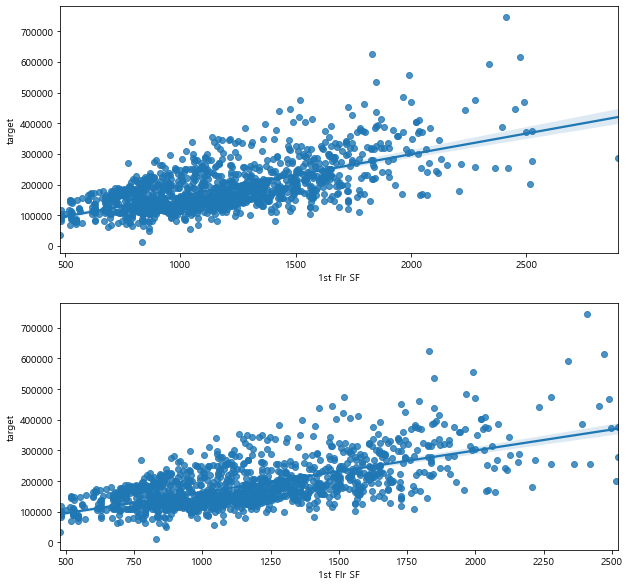

In [8]:
# 1st Flr SF : 1층 면적, describe값 이용해서 q3_plus_iqr*1.5 값 구함, 로컬, 퍼블릭 성능향상 확인
q_3_plus_iqr = (1396.500000 - 886.250000) * 1.5 + 1396.500000
print(q_3_plus_iqr)

train_re.loc[1098, '1st Flr SF'] = q_3_plus_iqr

# 분포의 변화 없이 하나의 이상치 값을 일반화시킴
fig, axes = plt.subplots(2, 1, figsize=(10, 10))
sns.regplot(data=train, x='1st Flr SF', y='target', ax=axes[0])
sns.regplot(data=train_re, x='1st Flr SF', y='target', ax=axes[1])
plt.show()

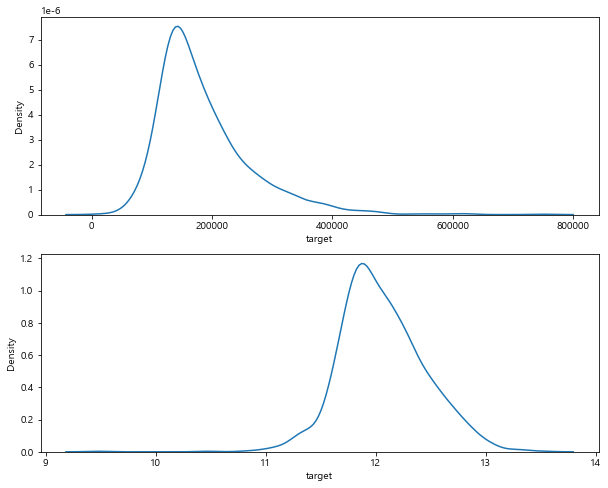

In [9]:
# target의 왜도를 줄여서 예측 (회귀에서는 타겟의 왜도를 줄여주고 예측하였을 때 성능이 잘 나온다는 것이 알려진바 있음)
log_target = np.log1p(target)

fig, axes = plt.subplots(2, 1, figsize=(10, 8))
sns.kdeplot(target, ax=axes[0])
sns.kdeplot(np.log1p(target), ax=axes[1])
plt.show()

In [10]:
# NaN 값 없음
train.isnull().sum().sum()

0

In [11]:
train_re = train_re.drop('target', axis=1)
train_re

,Overall Qual,Gr Liv Area,Exter Qual,Garage Cars,Garage Area,Kitchen Qual,Total Bsmt SF,1st Flr SF,Bsmt Qual,Full Bath,Year Built,Year Remod/Add,Garage Yr Blt
0,10,2392,Ex,3,968,Ex,2392,2392.0,Ex,2,2003,2003,2003
1,7,1352,Gd,2,466,Gd,1352,1352.0,Ex,2,2006,2007,2006
2,5,900,TA,1,288,TA,864,900.0,TA,1,1967,1967,1967
3,5,1174,TA,2,576,Gd,680,680.0,TA,1,1900,2006,2000
4,7,1958,Gd,3,936,Gd,1026,1026.0,Gd,2,2005,2005,2005
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1345,6,1756,Gd,2,422,TA,872,888.0,Ex,2,1996,1997,1996
1346,9,2748,Gd,3,850,Ex,1850,1850.0,Ex,2,2006,2006,2006
1347,5,1214,TA,1,318,TA,1214,1214.0,TA,2,1967,1967,1967
1348,5,894,TA,2,440,TA,864,894.0,Gd,1,1974,1974,1974


# 데이터 엔지니어링

#### 피처변환 - 라벨 인코딩

In [12]:
# Label Encoding
qual_cols = train_re.dtypes[train_re.dtypes == np.object].index
train_re = label_encoder(train_re, qual_cols)
test = label_encoder(test, qual_cols)
train_re.head()

,Overall Qual,Gr Liv Area,Exter Qual,Garage Cars,Garage Area,Kitchen Qual,Total Bsmt SF,1st Flr SF,Bsmt Qual,Full Bath,Year Built,Year Remod/Add,Garage Yr Blt
0,10,2392,5,3,968,5,2392,2392.0,5,2,2003,2003,2003
1,7,1352,4,2,466,4,1352,1352.0,5,2,2006,2007,2006
2,5,900,3,1,288,3,864,900.0,3,1,1967,1967,1967
3,5,1174,3,2,576,4,680,680.0,3,1,1900,2006,2000
4,7,1958,4,3,936,4,1026,1026.0,4,2,2005,2005,2005


#### 피처생성 - 군집화 피처

In [13]:
kmeans8 = KMeans(n_clusters=8, n_jobs=-1, random_state=seed)
kmeans8.fit(train_re)

train_re['kmeans_basic'] = kmeans8.labels_
test['kmeans_basic'] = kmeans8.predict(test)

#### 피처생성 - 파생변수

In [14]:
# 2층 면적 2nd flr SF= 지상층 생활 면적 - 1층 면적
train_re['2nd flr SF'] = train_re['Gr Liv Area'] - train_re['1st Flr SF']
test['2nd flr SF'] = test['Gr Liv Area'] - test['1st Flr SF']

# 전체 면적 Total SF = 지상층 생활 면적 + 지하실 면적 + 차고 면적
train_re['Total SF'] = train_re[['Gr Liv Area',"Garage Area", "Total Bsmt SF"]].sum(axis=1)
test['Total SF'] = test[['Gr Liv Area',"Garage Area", "Total Bsmt SF"]].sum(axis=1)

# 품질 합 Sum Qual = (전반적 + 부억 + 재료 + 지하실) 품질
train_re['Sum Qual'] = train_re[["Exter Qual", "Kitchen Qual", "Overall Qual"]].sum(axis=1)
test['Sum Qual'] = test[["Exter Qual", "Kitchen Qual", "Overall Qual"]].sum(axis=1)

# 차고 밖/안 Garage In/Out = 1(지상층 생활 면적 != 1층 면적), 0(지상층 생활 면적 == 1층 면적)
train_re['Garage InOut'] = train_re.apply(lambda x : 1 if x['Gr Liv Area'] != x['1st Flr SF'] else 0, axis=1)
test['Garage InOut'] = test.apply(lambda x : 1 if x['Gr Liv Area'] != x['1st Flr SF'] else 0, axis=1)

#### 피처변환 - log화

In [17]:
numeric_feats = train_re.dtypes[train_re.dtypes != "object"].index
skewed_feats = train_re[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness


Skew in numerical features: 



,Skew
Gr Liv Area,0.979219
Garage Area,0.885469
2nd flr SF,0.832824
Total SF,0.828661
1st Flr SF,0.788633
Exter Qual,0.774360
Total Bsmt SF,0.743464
Sum Qual,0.624271
kmeans_basic,0.457487
Kitchen Qual,0.433756


In [19]:
# 이 중에서 원래 범주형 변수였으며 수치 간 범위가 적은 피처를 제외하고 확인 및 log화 진행
skewness = skewness[abs(skewness)['Skew'] > 0.75]
skewness

,Skew
Gr Liv Area,0.979219
Garage Area,0.885469
2nd flr SF,0.832824
Total SF,0.828661
1st Flr SF,0.788633
Exter Qual,0.774360


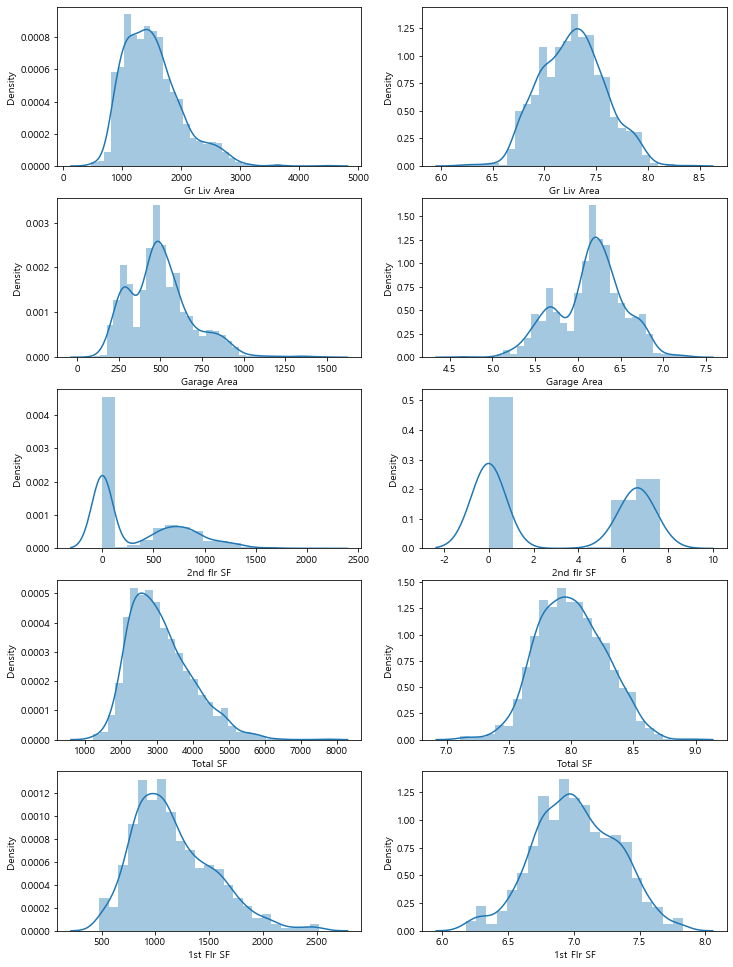

In [20]:
plt.figure(figsize=(12, 17))
plt.subplot(5,2,1)
ax = sns.distplot(train_re['Gr Liv Area'])
plt.subplot(5,2,2)
ax = sns.distplot(np.log1p(train_re['Gr Liv Area']))

plt.subplot(5,2,3)
ax = sns.distplot(train_re['Garage Area'])
plt.subplot(5,2,4)
ax = sns.distplot(np.log1p(train_re['Garage Area']))


plt.subplot(5,2,5)
ax = sns.distplot(train_re['2nd flr SF'])
plt.subplot(5,2,6)
ax = sns.distplot(np.log1p(train_re['2nd flr SF']))

plt.subplot(5,2,7)
ax = sns.distplot(train_re['Total SF'])
plt.subplot(5,2,8)
ax = sns.distplot(np.log1p(train_re['Total SF']))

plt.subplot(5,2,9)
ax = sns.distplot(train_re['1st Flr SF'])
plt.subplot(5,2,10)
ax = sns.distplot(np.log1p(train_re['1st Flr SF']))



In [21]:
skewness_features = ['Gr Liv Area', 'Garage Area', '2nd flr SF', 'Total SF', '1st Flr SF']
skewness_features

['Gr Liv Area', 'Garage Area', '2nd flr SF', 'Total SF', '1st Flr SF']

In [22]:
train_re[skewness_features] = np.log1p(train_re[skewness_features])
test[skewness_features] = np.log1p(test[skewness_features])

#### 피처변환 - 스케일링

In [23]:
# scaling된 데이터는 scaled를 붙임
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_re)
test_scaled = scaler.transform(test)
print(train_scaled.shape, test_scaled.shape)

(1350, 18) (1350, 18)


#### 최종 피처 선택

In [24]:
# selection의 약자로 sel를 사용
# 원래 이 부분에서 항상 percentile를 통한 피처설렉션 과정을 거치기에 약자인 'sel'를 이용하였는데, 피처가 적어 그대로 진행
train_sel = train_scaled
test_sel = test_scaled
print(train_sel.shape, test_sel.shape)

(1350, 18) (1350, 18)


# 모델링

#### 모델의 기본성능 체크

In [26]:
for reg in selected_regs:
    get_various_scores(reg, train_sel, log_target)

ExtraTreesRegressor            MAE: 0.1001 / MSE: 0.0233 / R2: 0.8427
LGBMRegressor                  MAE: 0.0988 / MSE: 0.0214 / R2: 0.8553
SVR                            MAE: 0.1001 / MSE: 0.0216 / R2: 0.8540
CatBoostRegressor              MAE: 0.0945 / MSE: 0.0191 / R2: 0.8712


#### 튜닝 - 랜덤서치

**튜닝 성능**<br>
ExtraTreesRegressor            score: -0.0956, takes 173.4 secs<br>
LGBMRegressor                  score: -0.0956, takes 114.9 secs<br>
SVR                            score: -0.0970, takes 3.6 secs<br>
CatBoostRegressor              score: -0.0933, takes 6263.5 secs<br>

# 앙상블

In [49]:
tuned_models = []

# extra, lgb, cat
with_seq_model_lst = joblib.load('./MODELS/RS_tuned_regs_2022-01-31_withSeq.pkl')
tuned_models.append(with_seq_model_lst[0][1])
tuned_models.append(with_seq_model_lst[1][1])
tuned_models.append(with_seq_model_lst[3][1])

# svr
without_seq_model_lst = joblib.load('./MODELS/RS_tuned_regs_2022-01-31pkl')
tuned_models.append(without_seq_model_lst[2][1])

tuned_models

[ExtraTreesRegressor(max_depth=14, max_features=0.8, min_samples_leaf=3,
                     n_estimators=175, n_jobs=-1, random_state=42),
 LGBMRegressor(colsample_bytree=0.85, learning_rate=0.05, max_depth=19,
               random_state=42, subsample=0.875),
 SVR(C=5, gamma=0.01)]

#### Seed_Ensemble

In [62]:
for model in tuned_models:
    
    ### Get tuned model
    best_model = model
    print(f'Start {best_model.__class__.__name__} Seed Ensemble')

    ### Make folders for saving models
    now = datetime.datetime.now()
    nowDate = now.strftime('%Y-%m-%d')
    if os.path.exists('MODELS') == False:
        os.mkdir('MODELS')
    if os.path.exists(f'MODELS/seed_ensemble_{nowDate}_{best_model.__class__.__name__}') == False:
        os.mkdir(f'MODELS/seed_ensemble_{nowDate}_{best_model.__class__.__name__}')

    ### Set random seed
    lucky_seeds = [36, 42, 82, 88]
    scores = []
    for iter_count, seed in enumerate(lucky_seeds):
        best_model.random_state = seed
        new_kfold = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
        #new_rkf = RepeatedKFold(n_splits=n_splits, n_repeats=2, random_state=seed)

        fit_best_model(best_model, train_sel, log_target, new_kfold)

    print(f'\n모델 {len(lucky_seeds) * new_kfold.n_splits}개 학습 완료 !')
    print(f'{best_model.__class__.__name__} 모델의 Seed Ensemble 평균 성능: {np.mean(scores):.4f}')

    ### Get model names
    model_names = os.listdir(f'MODELS/seed_ensemble_{nowDate}_{best_model.__class__.__name__}')
    model_lst = [x for x in model_names if x.endswith(".pkl")]
    assert len(model_lst) == len(lucky_seeds) * new_kfold.n_splits


    ### Predict test and Get gmean
    preds = []
    for model_name in model_lst:
        model = joblib.load(f'MODELS/seed_ensemble_{nowDate}_{best_model.__class__.__name__}/'+model_name)
        predict_ = model.predict(test_sel)
        preds.append(predict_)
    pred_mean = gmean([pred for pred in preds])
    pred_mean_expm = np.expm1(pred_mean)

    submission = pd.DataFrame({
        'id': sample_sub.id,
        'target': pred_mean_expm
    })

    submission.to_csv(f'./SUBMISSIONS/seed_Ensemble_submission_{nowDate}_{best_model.__class__.__name__}.csv', index=False)
    print('Seed Ensemble submission 출력 완료!\n')

Start ExtraTreesRegressor Seed Ensemble
SEED: 36, 평균성능: 0.0957
SEED: 42, 평균성능: 0.0956
SEED: 82, 평균성능: 0.0955
SEED: 88, 평균성능: 0.0959

모델 20개 학습 완료 !
ExtraTreesRegressor 모델의 Seed Ensemble 평균 성능: 0.0957
Seed Ensemble submission 출력 완료!

Start LGBMRegressor Seed Ensemble
SEED: 36, 평균성능: 0.0965
SEED: 42, 평균성능: 0.0956
SEED: 82, 평균성능: 0.0965
SEED: 88, 평균성능: 0.0961

모델 20개 학습 완료 !
LGBMRegressor 모델의 Seed Ensemble 평균 성능: 0.0962
Seed Ensemble submission 출력 완료!

Start CatBoostRegressor Seed Ensemble
SEED: 36, 평균성능: 0.0942
SEED: 42, 평균성능: 0.0933
SEED: 82, 평균성능: 0.0940
SEED: 88, 평균성능: 0.0938

모델 20개 학습 완료 !
CatBoostRegressor 모델의 Seed Ensemble 평균 성능: 0.0938
Seed Ensemble submission 출력 완료!

Start SVR Seed Ensemble
SEED: 36, 평균성능: 0.0972
SEED: 42, 평균성능: 0.0978
SEED: 82, 평균성능: 0.0970
SEED: 88, 평균성능: 0.0972

모델 20개 학습 완료 !
SVR 모델의 Seed Ensemble 평균 성능: 0.0973
Seed Ensemble submission 출력 완료!



In [73]:
train_sel_withoutseq = pd.read_csv('./DATA/train_18features_withoutSeq.csv').values
test_sel_withoutseq = pd.read_csv('./DATA/test_18features_withoutSeq.csv').values

In [77]:

### Get tuned model
best_model = tuned_models[3]
print(f'Start {best_model.__class__.__name__} Seed Ensemble')

### Make folders for saving models
now = datetime.datetime.now()
nowDate = now.strftime('%Y-%m-%d')
if os.path.exists('MODELS') == False:
    os.mkdir('MODELS')
if os.path.exists(f'MODELS/seed_ensemble_{nowDate}_{best_model.__class__.__name__}') == False:
    os.mkdir(f'MODELS/seed_ensemble_{nowDate}_{best_model.__class__.__name__}')

### Set Random Seed
lucky_seeds = [36, 42, 82, 88]
scores = []
for iter_count, seed in enumerate(lucky_seeds):
    best_model.random_state = seed
    new_kfold = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    #new_rkf = RepeatedKFold(n_splits=n_splits, n_repeats=2, random_state=seed)

    fit_best_model(best_model, train_sel_withoutseq, log_target, new_kfold)

print(f'\n모델 {len(lucky_seeds) * new_kfold.n_splits}개 학습 완료 !')
print(f'{best_model.__class__.__name__} 모델의 Seed Ensemble 평균 성능: {np.mean(scores):.4f}')

### Get model names
model_names = os.listdir(f'MODELS/seed_ensemble_{nowDate}_{best_model.__class__.__name__}')
model_lst = [x for x in model_names if x.endswith(".pkl")]
assert len(model_lst) == len(lucky_seeds) * new_kfold.n_splits # 숫자가 맞지 않으면 에러출력


### Predict test and Get gmean
preds = []
for model_name in model_lst:
    model = joblib.load(f'MODELS/seed_ensemble_{nowDate}_{best_model.__class__.__name__}/'+model_name)
    predict_ = model.predict(test_sel_withoutseq)
    preds.append(predict_)
pred_mean = gmean([pred for pred in preds])
pred_mean_expm = np.expm1(pred_mean)

submission = pd.DataFrame({
    'id': sample_sub.id,
    'target': pred_mean_expm
})

submission.to_csv(f'./SUBMISSIONS/seed_Ensemble_submission_{nowDate}_{best_model.__class__.__name__}.csv', index=False)
print('Seed Ensemble submission 출력 완료!\n')

Start SVR Seed Ensemble
SEED: 36, 평균성능: 0.0964
SEED: 42, 평균성능: 0.0970
SEED: 82, 평균성능: 0.0969
SEED: 88, 평균성능: 0.0965

모델 20개 학습 완료 !
SVR 모델의 Seed Ensemble 평균 성능: 0.0967
Seed Ensemble submission 출력 완료!



In [4]:
extra_20gmean_pred = pd.read_csv('./SUBMISSIONS/seed_Ensemble_submission_2022-02-02_ExtraTreesRegressor.csv')['target']
lgb_20gmean_pred = pd.read_csv('./SUBMISSIONS/seed_Ensemble_submission_2022-02-02_LGBMRegressor.csv')['target']
cat_20gmean_pred = pd.read_csv('./SUBMISSIONS/seed_Ensemble_submission_2022-02-02_CatBoostRegressor.csv')['target']
svr_20gmean_pred = pd.read_csv('./SUBMISSIONS/seed_Ensemble_submission_2022-02-02_SVR.csv')['target']

In [56]:
# 점수가 낮은 것부터 차례대로 기하평균
gmean_seed_ensemble_from_low = (cat_20gmean_pred * (extra_20gmean_pred * ((lgb_20gmean_pred * svr_20gmean_pred) ** (1/2))) ** (1/2)) ** (1/2)

In [57]:
submission = pd.DataFrame({
    'id': sample_sub.id,
    'target': gmean_seed_ensemble_from_low
})

submission.to_csv(f'./SUBMISSIONS/seed_Ensemble_extra_lgb_cat_svr_gmean_from_low.csv', index=False)
print('Seed Ensemble된 서브미션끼리 가중평균 출력 !\n')
pd.read_csv('./SUBMISSIONS/seed_Ensemble_extra_lgb_cat_svr_gmean_from_low.csv')

Seed Ensemble된 서브미션끼리 가중평균 출력 !



,id,target
0,1,329766.033371
1,2,128863.760326
2,3,177085.693655
3,4,259466.506620
4,5,132977.987808
...,...,...
1345,1346,346724.533095
1346,1347,124139.058380
1347,1348,77162.312726
1348,1349,191197.125796


In [69]:
# 점수가 높은 것부터 차례대로 기하평균
gmean_seed_ensemble_from_top = (svr_20gmean_pred * (lgb_20gmean_pred * ((cat_20gmean_pred * extra_20gmean_pred) ** (1/2))) ** (1/2)) ** (1/2)

In [5]:
submission = pd.DataFrame({
    'id': sample_sub.id,
    'target': gmean_seed_ensemble_from_tmp
})

submission.to_csv(f'./SUBMISSIONS/seed_Ensemble_extra_lgb_cat_svr_gmean_from_top.csv', index=False)
pd.read_csv('./SUBMISSIONS/seed_Ensemble_extra_lgb_cat_svr_gmean_from_top.csv')

,id,target
0,1,333074.813154
1,2,128871.402269
2,3,177131.516114
3,4,258361.159076
4,5,134133.538130
...,...,...
1345,1346,328816.468819
1346,1347,123093.346574
1347,1348,76517.489226
1348,1349,189745.764686


In [84]:
# 최종 기하평균 앙상블
gmean_seed_ensemble_low_top = (gmean_seed_ensemble_from_low * 0.95 +  gmean_seed_ensemble_from_top * 0.05)

In [85]:
submission = pd.DataFrame({
    'id': sample_sub.id,
    'target': gmean_seed_ensemble_low_top
})

submission.to_csv(f'./SUBMISSIONS/seed_Ensemble_extra_lgb_cat_svr_gmean_low_top.csv', index=False)
pd.read_csv('./SUBMISSIONS/seed_Ensemble_extra_lgb_cat_svr_gmean_low_top.csv')

,id,target
0,1,329931.472360
1,2,128864.142423
2,3,177087.984778
3,4,259411.239243
4,5,133035.765324
...,...,...
1345,1346,345829.129881
1346,1347,124086.772789
1347,1348,77130.071551
1348,1349,191124.557740


**─────────────────── End of Pipeline ───────────────────**